This script explains the models that are used for training a physics informed neural networks (PINN). Furthermore, it explains how to use the classes in main.py to train the PINNs and reproduce the results. 

But first, what are PINNs? PINNs are neural networks that are combined with physical laws or principles to include existing knowledge about the underlying physics of a system in the training process. This improves the accuracy of predictions and allows training with limited data. 

In this work, three simple reactor models and one complex reactor model were set up to train the PINNs and compare the solution with the analytical solution by solving the ODEs with an ODE-solver of skipy.

In [ ]:
# Import all libraries that are needed
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import os

## Simple Reactor Model

First, we look at the simple model for solving a PFR. In this model, the kinetics of an equimolar equilibrium reaction is implemented:

$A\rightleftharpoons B$

The following mass balances are solved:

$\frac{dn_{\rm{A}}}{dz} = A \cdot (-r_{\rm{total}})$, $\quad\frac{dn_{\rm{B}}}{dz} = A \cdot (r_{\rm{total}})$

The total reaction rate is determined from the kinetic data of the forward reaction:

$k_{\rm{hin}} = k_{0,\rm{hin}} \cdot e^{\frac{E_{\rm{A,hin}}}{R\cdot T}}$

$r_{\rm{hin}} = k_{\rm{hin}} \cdot c_{\rm{A}}$

$r_{\rm{total}} = r_{\rm{hin}} \cdot\left(1-\frac{K(T)}{K(T=600\,\rm{K})}\right)$

There are three approaches for the heat balance: Isothermal, adiabatic and polytrop PFR.

Isothermal: $\frac{dT}{dz} = 0$

Adiabatic: $\frac{dT}{dz} = \frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\underbrace{\left(A\cdot\sum\limits_{j}r_{j}(-\Delta_{\rm{R}}H_{j})\right)}_{\substack{Reaction}}$

Polytropic: $\frac{dT}{dz} = \frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\left(\underbrace{A\cdot\sum\limits_{j}r_{j}(-\Delta_{\rm{R}}H_{j})}_{\substack{Reaction}} + \underbrace{U_{\rm{perV}}\cdot\left(T-T_{\rm{wall}}\right)}_{\substack{Heating/Cooling}}\right)$

Based on this model, we will now look at how the analytical solution is generated.

In [ ]:
# Define parameters for the reactor model
reactor_lengths = np.linspace(0,10,num=100)
inlet_conds = [0.1,0,0.9,600] #x_A0,x_B0,x_N20,T0
bound_conds = [1,1] #p,u
species_conds = [6*1e8,1e5,30,4e4,10] #k1,cp,Hr,E_A,k0
reactor_conds = [100,0.1,10,600] #U_perv,A_reactor,L_reactor,T_bath

The defined parameters are not explained in more detail, because they are explained in the class. Important for the user is the thermo_state, which can be used to switch between the different heat balances, and plot_analytical_solution, which can be used to plot the solution. In the following, the analytical solution for the three cases is calculated and plotted.

In [ ]:
# Import the class
from simple_PFR.main import generate_data

# Generate an instance of the class
model = generate_data(inlet_conds, bound_conds, species_conds, reactor_conds)

# Generate data by using the method solve_ode
model.solve_ode(thermo_state='isotherm', reactor_lengths=reactor_lengths, plot=True)
model.solve_ode(thermo_state='adiabatic', reactor_lengths=reactor_lengths, plot=True)
model.solve_ode(thermo_state='polytrop', reactor_lengths=reactor_lengths, plot=True)

The curves show that the calculation of the analytical solution worked. Next, we focus on setting up the PINN. To do this, we will first look at what is behind the model.

How will the neural network be trained? First, a network architecture has to be selected and then the weights and biases are initialised, which are set randomly. Then the input data is sent through the network by propagating it through each layer. The activation functions in the neurons determine whether and how much a neuron is activated. This is followed by the training of the PINN. Here, the error is calculated using loss functions, where the loss function measures how well the neuornal network performs. Backpropagation is used to propagate the error backwards through the network to adjust the weights and biases with the chosen optimisation algorithm to minimise the error. During training, the process of forward and backward propagation is repeated several times until the number of epochs is reached. Afterwards, the predicted values from the forward propagation can be used to compare them with the analytical solution.

What network architecture is used here? The first layer contains one neuron, which contains the reactor lengths. The number of hidden layers and the number of neurons can be freely chosen here, but in this example few layers and neurons are needed to ensure high accuracy. In the last layer there are three neurons that contain the predicted solutions of the ODEs.

Which optimiser is used here? We use the limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) optimiser. The optimiser uses limited memory to deal efficiently with large models, and it is particularly useful for optimisation problems with many parameters. In our case, the learning rate is set to 1. In L-BFGS, the learning rate is handled differently than in traditional optimisers like gradient descent. Here it does not control the step size, but influences the "memory" of the optimiser and the amount of information it uses for updating. Furthermore, in our case, strict convergence criteria are set that must be undercut for the optimiser to consider the optimisation converged.

Which loss functions are used? In our case, the Mean Squared Error (MSE) is used as a loss function, which works well for regression problems. For the calculation of the total loss, the following loss functions are used and weighted with weighting factors so that the user can weight the losses himself:

$L_{\rm{GE,A}} = \frac{1}{1000}\sum\limits_{i=1}^{N=1000}\left(\frac{d\hat{\dot n}_{\rm{A}}}{dz}-\left[A \cdot \left(-r_{\rm{total}}(\hat{c}_{\rm{A}},\hat{c}_{\rm{B}},\hat{T})\right)\right]\right)$

$L_{\rm{GE,B}} = \frac{1}{1000}\sum\limits_{i=1}^{N=1000}\left(\frac{d\hat{\dot n}_{\rm{B}}}{dz}-\left[A \cdot \left(r_{\rm{total}}(\hat{c}_{\rm{A}},\hat{c}_{\rm{B}},\hat{T})\right)\right]\right)$

$L_{\rm{GE,T}} = \frac{1}{1000}\sum\limits_{i=1}^{N=1000}\left(\frac{d\hat{T}}{dz}-\left[\frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\left(A\cdot\sum\limits_{j}r_{j}(\hat{c}_{\rm{A}},\hat{c}_{\rm{B}},\hat{T})(-\Delta_{\rm{R}}H_{j})+ U_{\rm{perV}}\cdot\left(T-T_{\rm{wall}}\right)\right)\right]\right)$

$L_{\rm{IC,A}} = \left[\hat{\dot n}_{\rm{A}}(z=0)-\dot n_{\rm{A}}(z=0)\right]^{2}$

$L_{\rm{IC,B}} = \left[\hat{\dot n}_{\rm{B}}(z=0)-\dot n_{\rm{B}}(z=0)\right]^{2}$

$L_{\rm{IC,T}} = \left[\hat{T}(z=0)-T(z=0)\right]^{2}$

$L_{\rm{AB}} = w_{\rm{IC,AB}}\cdot\left(L_{\rm{IC,A}}+L_{\rm{IC,B}}\right)+w_{\rm{GE,AB}}\cdot\left(L_{\rm{GE,A}}+L_{\rm{GE,B}}\right)$

$L_{\rm{T}} = w_{\rm{IC,T}}*L_{\rm{IC,T}}+w_{\rm{GE,T}}*L_{\rm{GE,T}}$

$L_{\rm{total}} = w_{\rm{AB}}\cdot L_{\rm{AB}} + w_{\rm{T}}\cdot L_{\rm{T}}$

Here, the variables $\hat{\dot n}_{\rm{A}}$, $\hat{\dot n}_{\rm{B}}$, $\hat{c}_{\rm{A}}$, $\hat{c}_{\rm{B}}$ and $\hat{T}$ are predicted by the neural network $N(z)$. In the following section, the neural network is trained with the previous model:

In [ ]:
# Define parameters for the neural network
input_size_NN = 1
hidden_size_NN = 32
output_size_NN = 3
num_layers_NN = 3
num_epochs = 100
weight_factors = [1e3,1,1,1,1,1] #w_AB,w_T,w_GE_AB,w_GE_T,w_IC_AB,w_IC_T
epsilon = 0 #epsilon=0: without causal training, epsilon!=0: with causal training
plot_interval = 10 # Plotting during NN-training
thermo_state='polytrop'

The variables input_size_NN, hidden_size_NN and output_size_NN specify the number of neurons in the corresponding layers. The variable num_layers_NN indicates the number of hidden layers and the variable num_epochs indicates the number of epochs in the training. The weighting factors are initially all set to 1 and will be varied later. The variable epsilon belongs to the causal algorithm, which will be explained in more detail later. So that it does not change the loss function, it is set to 0. The variable plot_interval specifies the interval of epochs at which the plots are created. These are stored in a "plots" folder generated by the program and can be examined during the training. For illustrative purposes, the plots are not created here, but examples are inserted. The next step is to train the PINN without causal training. To do this, we first need to generate the analytical data to compare with the PINN's predictions.

In [ ]:
# Import all classes
from simple_PFR.main import *

# Generate analytical data
model.solve_ode(thermo_state=thermo_state, reactor_lengths=reactor_lengths, plot=False)

analytical_solution_x_A = model.x_A
analytical_solution_x_B = model.x_B
analytical_solution_T = model.T

# Set up the neural network
network = NeuralNetwork(input_size_NN=input_size_NN, hidden_size_NN=hidden_size_NN,\
                        output_size_NN=output_size_NN, num_layers_NN=num_layers_NN,\
                        T0 = inlet_conds[3])
optimizer = torch.optim.LBFGS(network.parameters(), lr=1, line_search_fn= \
                              "strong_wolfe", max_eval=None, tolerance_grad \
                                =1e-50, tolerance_change=1e-50)
        
x = torch.tensor(reactor_lengths.reshape(-1, 1), requires_grad=True)
y = None
init_conds = torch.tensor([model.n_A0, model.n_B0, model.T0], requires_grad=True)
    
# Train the neural network
calc_loss = PINN_loss(weight_factors, init_conds, bound_conds, species_conds, \
                        reactor_conds, model.n_N20*torch.ones_like(x), epsilon) 
loss_values, msd_NN = \
    train(x, y, network, calc_loss, optimizer, num_epochs, thermo_state, \
            analytical_solution_x_A, analytical_solution_x_B, model.n_N20, \
                analytical_solution_T, plot_interval)

During training, three variables are monitored: the current epoch/ iteration of the training, the total loss and the causal weights sum. The latter will be explained in more detail later. The following plots show the mole fractions and temperature as a function of reactor length from the analytical solution and the prediction of the PINN. The number of epochs is set to 500 in both cases.

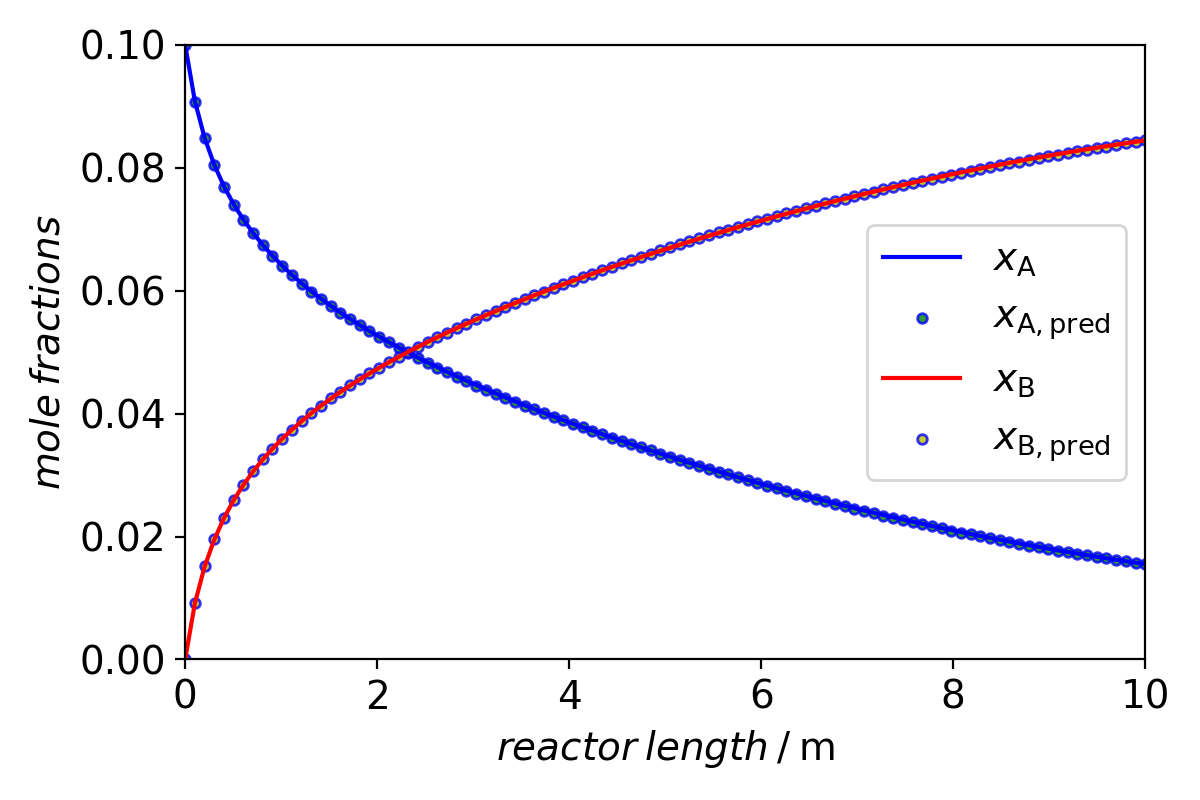

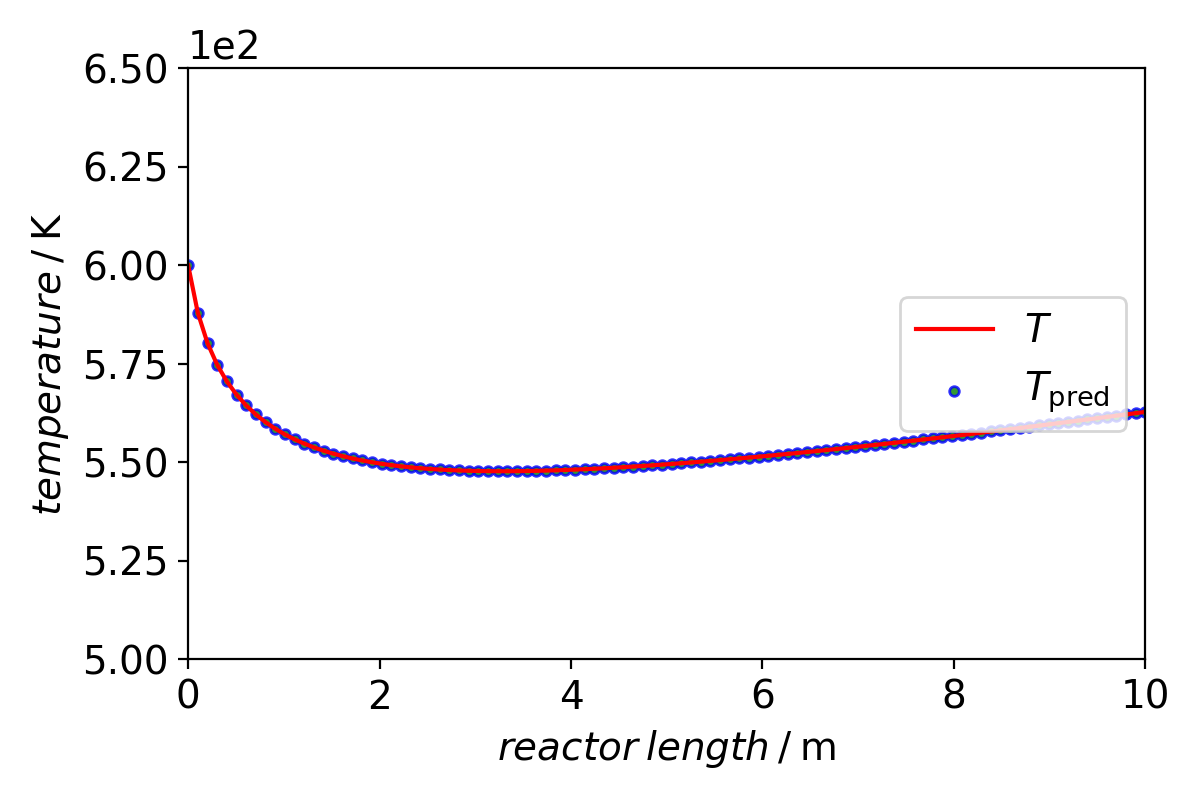

So far we have used optimised values for the weighting factors of the loss functions. How can the weighting factors be optimised? First, it is possible to think about the effects of the loss function of the governing equation (GE) and the loss of the initial condition (IC) on the training. The IC reduces the error of the variables at z=0. The GE has an effect on the quality of all predicted values from $x=0$ to $x=L_{\rm{reactor}}$. Alternatively, it is possible to monitor the values of all loss functions and adjust the weighting factors so that the losses are of similar magnitude. In the following, the losses of all loss functions are plotted for the previous example.

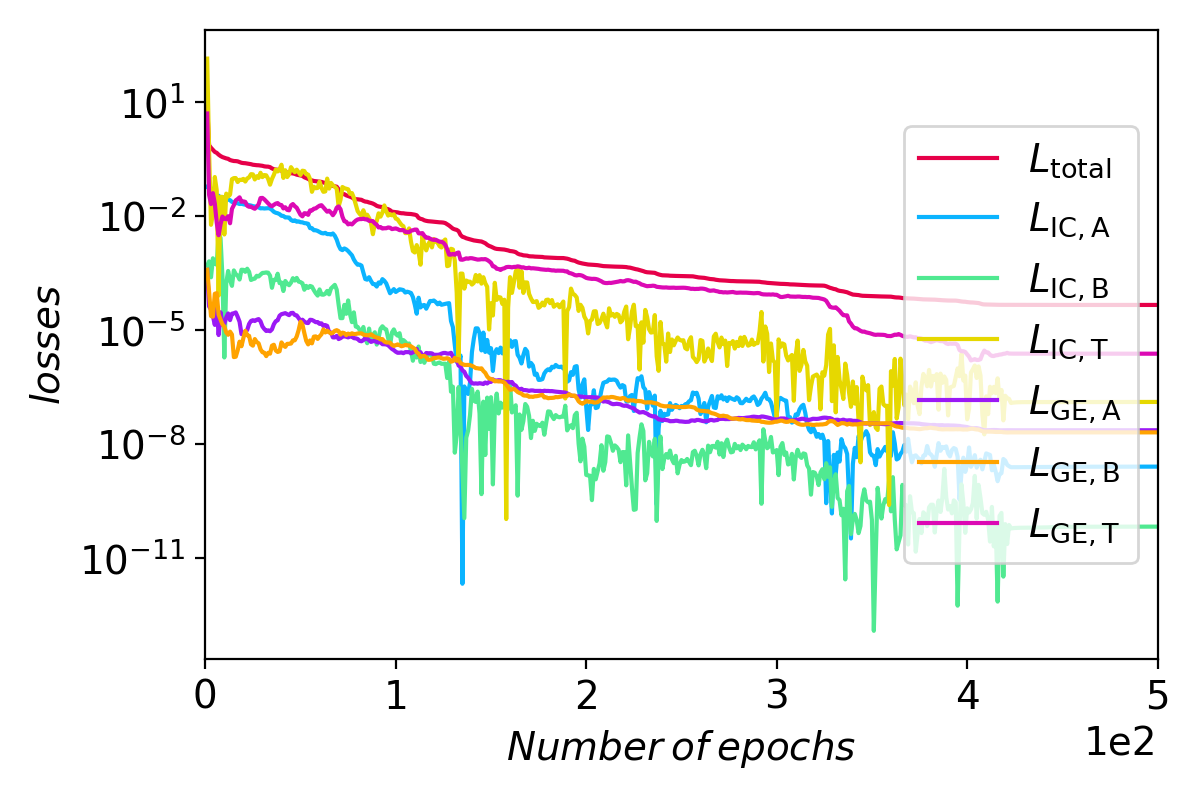

In our example, it is obvious that the losses of the IC and GE are much larger than the other losses by several orders of magnitude. For this reason, we have also increased all losses related to the mole fractions by a factor of 100. 

In the next example, we use an algorithm for training the PINN that has always been referred here as causal training. What does causal training mean? Previously, we averaged the losses of all points, which caused the neural network to try to reduce the gradient of all points equally. With causal training, we implement a new approach in which the points are optimised one after the other by considering weighting factors for the individual points. The idea behind this is that the points are related to each other and the error in the points at the beginning of the reactor has an influence on the error in the points later in the reactor and thus accumulate. The error can be reduced by first reducing the error at the beginning of the reactor and over time taking more points into account when calculating the error. This method should also prevent the PINN from converging to a local minimum rather than a global minimum. Equations used in causal training:

$L_{r}(\theta) = \frac{1}{N_{t}}\sum\limits_{i=1}^{N_{t}}w_{i}L_{r}(t_{i},\theta)$

$w_{i} = \rm{exp}\left(-\epsilon\sum\limits_{\it{k}=1}^{\it{i}\,-\,1}\it{L}_{\it{r}}(\it{t}_{\it{k}},\theta)\right),\:\rm{for}\:\it{i}=2,3,...,N_{t}$

To use causal training, the causality parameter epsilon must be set to a value not equal 0.

In [ ]:
# Set the causality parameter unequal to 0
num_epochs = 250
epsilon = 2

# Generate analytical data
model.solve_ode(thermo_state=thermo_state, reactor_lengths=reactor_lengths, plot=False)

analytical_solution_x_A = model.x_A
analytical_solution_x_B = model.x_B
analytical_solution_T = model.T

# Set up the neural network
network = NeuralNetwork(input_size_NN=input_size_NN, hidden_size_NN=hidden_size_NN,\
                        output_size_NN=output_size_NN, num_layers_NN=num_layers_NN,\
                        T0 = inlet_conds[3])
optimizer = torch.optim.LBFGS(network.parameters(), lr=1, line_search_fn= \
                              "strong_wolfe", max_eval=None, tolerance_grad \
                                =1e-50, tolerance_change=1e-50)
        
x = torch.tensor(reactor_lengths.reshape(-1, 1), requires_grad=True)
y = None
init_conds = torch.tensor([model.n_A0, model.n_B0, model.T0], requires_grad=True)
    
# Train the neural network
calc_loss = PINN_loss(weight_factors, init_conds, bound_conds, species_conds, \
                        reactor_conds, model.n_N20*torch.ones_like(x), epsilon) 
loss_values, msd_NN = \
    train(x, y, network, calc_loss, optimizer, num_epochs, thermo_state, \
            analytical_solution_x_A, analytical_solution_x_B, model.n_N20, \
                analytical_solution_T, plot_interval)

How can the causality parameter be optimised? For this we need the monitored causal weighted sum. This value is the sum of the weighting factors of all points and shows us how many points are considered in the training. In order for the model to be used reasonably, only the points at the beginning should be used for the training and only with time should further points be taken into account. If too many points are taken into account too early, then it is possible that the result will not differ from the previous training method.

The results are shown in the following plots:

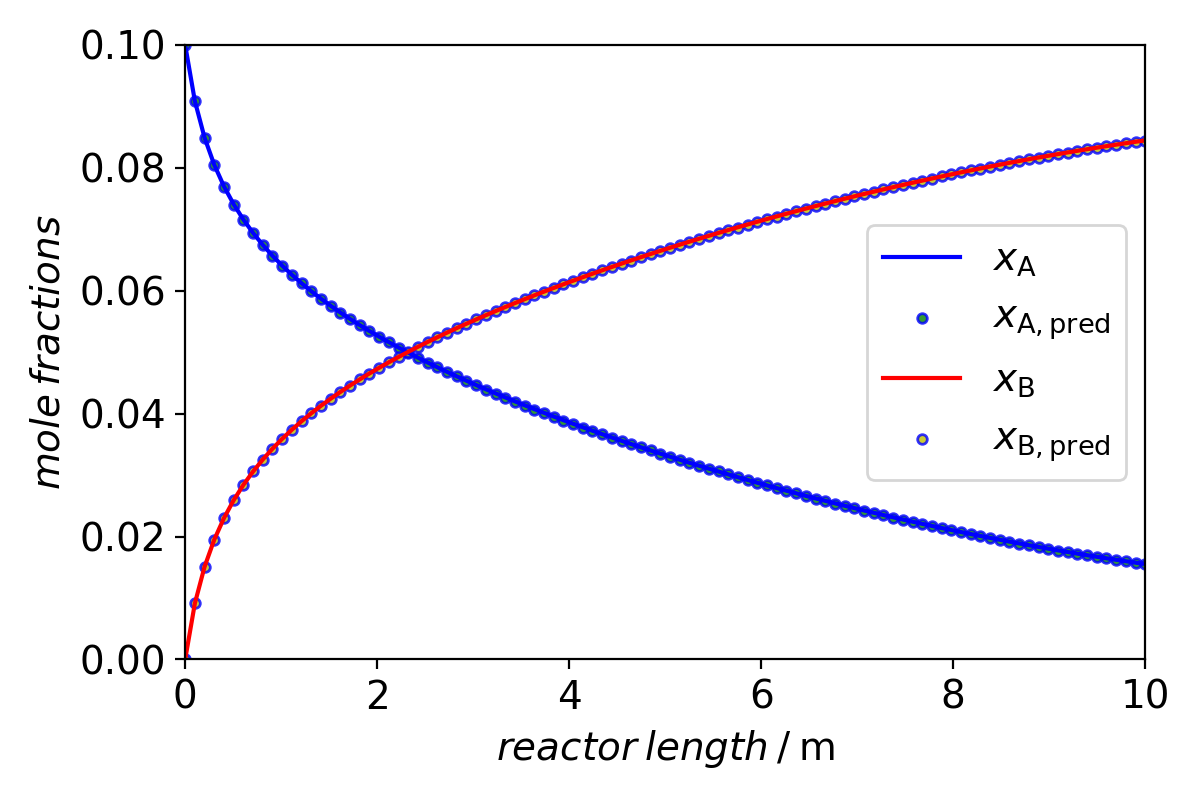

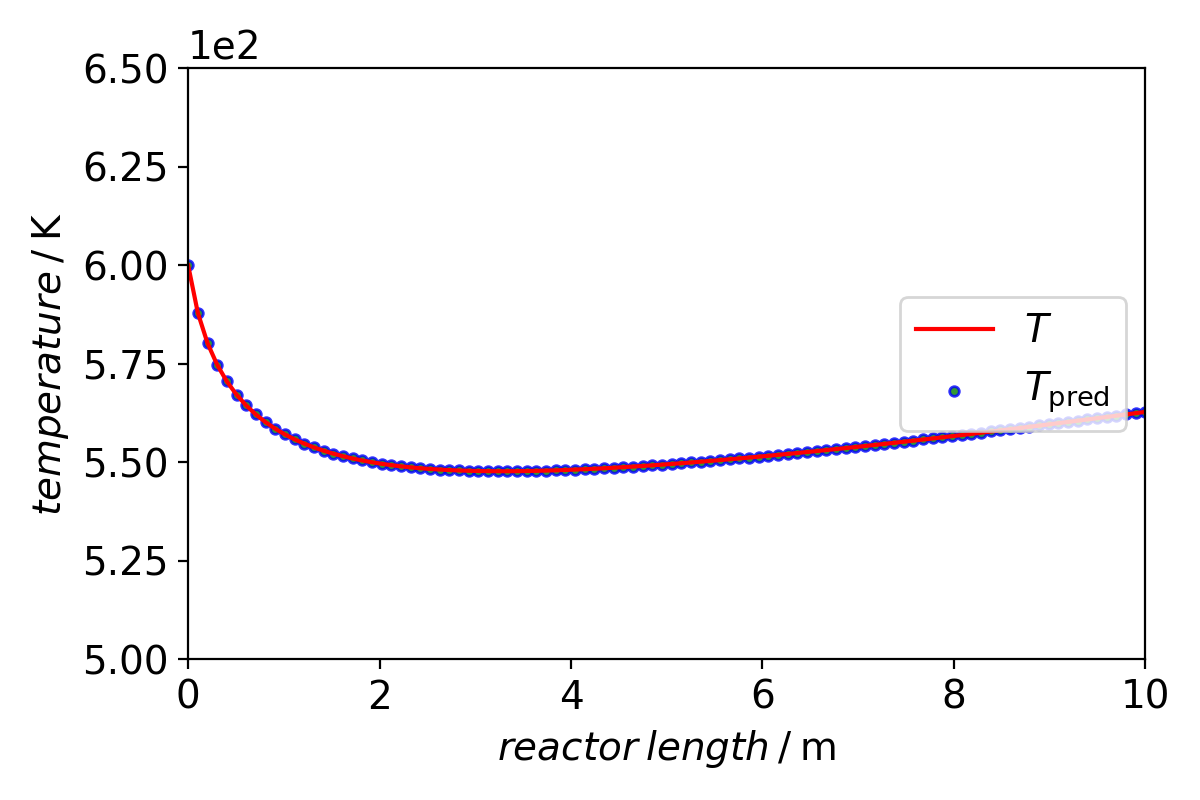

## Methane Steam Reformer

The simple reactor is a very simplified reactor model of a PFR. For this reason, we will deal with a more complex reactor model in the next section. In the next reactor model, we simulate a methane steam reformer in which three reactions are considered: (1) Steam Reforming,  (2) Water Gas Shift and (3) Direct Reforming.

$(1)\:\rm{CH}_{4} + \rm{H}_{2}\rm{O} \rightleftharpoons \rm{CO} + 3\rm{H}_{2}$

$(2)\:\rm{CO} + \rm{H}_{2}\rm{O} \rightleftharpoons \rm{CO}_{2} + \rm{H}_{2}$

$(3)\:\rm{CH}_{4} + 2\rm{H}_{2}\rm{O} \rightleftharpoons \rm{CO}_{2} + 4\rm{H}_{2}$

The reactor is a fixed-bed reactor of which a single fixed-bed pipe is simulated. The reactor model is a pseudo-homogeneous fixed-bed reactor, which is solved one-dimensionally. Using the ideal gas law, the dependence of the flow velocity on the temperature and gas composition is taken into account.

$u_{\rm{gas}}(T_{2}) = u_{\rm{gas}}(T_{1})\frac{T_{2}}{T_{1}}\frac{\overline{M}_{\rm{ges}}(T_{1})}{\overline{M}_{\rm{ges}}(T_{2})}$

The temperature-dependent reaction enthalpy and entropy are calculated for each reactor point. The reaction enthalpies and entropies are calculated from the standard enthalpies and entropies of formation according to Hess's theorem, the heat capacities are calculated using NASA polynomials and integrated as a function of temperature. The equilibrium constants can then be determined from the reaction enthalpies and entropies using the Gibbs-Helmholtz equation.

$c_{\rm{p},i}^{⦵}(T) = A_{i,1}\cdot T + \frac{1}{2}\cdot A_{i,2}\cdot T^{2} + \frac{1}{3}\cdot A_{i,3}\cdot T^{3}+\frac{1}{4}\cdot A_{i,4}\cdot T^{4}$

$H_{i}(T) = H_{i}^{⦵}(T_{0}) + \int\limits^{T_{2}}_{T_{1}}c_{\rm{p},\it{i}}^{⦵}(T)dT$

$\Delta_{\rm{R}}H_{j}=\sum\limits_{i} \nu_{i,j}\cdot H_{i}(T)$

$S_{i}(T) = S_{i}^{⦵}(T_{0}) + \int\limits^{T_{2}}_{T_{1}}\frac{c_{\rm{p},\it{i}}^{⦵}(T)}{T}dT$

$\Delta_{\rm{R}}S_{j}=\sum\limits_{i} \nu_{i,j}\cdot S_{i}(T)$

$\Delta_{\rm{R}}G_{j} = \Delta_{\rm{R}}H_{j} - T\cdot \Delta_{\rm{R}}S_{j}$

$K_{\rm{p,\,\it{j}}}=\rm{e}^{\frac{-\Delta_{\rm{R}}\it{G_{j}}}{\rm{R}\cdot \it{T}}}$

The index $i$ denotes the reactant and $j$ the reaction. The model also uses a Langmuir-Hinshelwood approach developed by Xu and Froment. Therefore, the following equations are used for the mass balance:

$k_{j} = k_{0,j} \cdot \rm{e}^{\frac{-\it{E}_{\rm{A,\it{j}}}}{\rm{R}\cdot \it{T}}}$

$K_{i} = K_{0,i} \cdot \rm{e}^{\frac{\Delta_{\rm{R}}\it{G}_{\rm{ads}}}{\rm{R}\cdot \it{T}}}$

$\rm{DEN} = 1+\it{p}_{\rm{CO}}\cdot \it{K}_{\rm{CO}}+\it{p}_{\rm{H}_{2}}\cdot \it{K}_{\rm{\rm{H}_{2}}}+\it{p}_{\rm{CH}_{4}}\cdot \it{K}_{\rm{CH}_{4}}+\frac{\it{p}_{\rm{H}_{2}\rm{O}}\cdot \it{K}_{\rm{H}_{2}\rm{O}}}{\it{p}_{\rm{H}_{2}}}$

$r_{1} = \frac{k_{1}}{p_{\rm{H}_{2}}^{2.5}}\left(p_{\rm{CH}_{4}p_{\rm{H}_{2}\rm{O}}}-\frac{p_{\rm{H}_{2}}^{3}p_{\rm{CO}}}{K_{\rm{ads},1}}\right)\Large{/}\normalsize{\left(\rm{DEN}\right)^{2}}$

$r_{2} = \frac{k_{2}}{p_{\rm{H}_{2}}}\left(p_{\rm{CO}}p_{\rm{H}_{2}\rm{O}}-\frac{p_{\rm{H}_{2}}p_{\rm{CO}_{2}}}{K_{\rm{ads},2}}\right)\Large{/}\normalsize{\left(\rm{DEN}\right)^{2}}$

$r_{3} = \frac{k_{3}}{p_{\rm{H}_{2}}^{3.5}}\left(p_{\rm{CH}_{4}}p_{\rm{H}_{2}\rm{O}}^{2}-\frac{p_{\rm{H}_{2}}^{4}p_{\rm{CO}_{2}}}{K_{\rm{ads},3}}\right)\Large{/}\normalsize{\left(\rm{DEN}\right)^{2}}$

$\frac{dn_{i}}{dz} = \eta\cdot A_{\rm{PFR}}\cdot\sum\limits_{j}\nu_{i,j}r_{j}$

Heat transfer is important in the steam reforming process. For the 1-dimensional case, the heat transfer from the wall to the fixed bed and through the fixed bed can be represented with the help of a heat transfer coefficient U. In our case, we assume a constant value for the heat transfer coefficient $U_{\rm{perV}}$. The assumption is justified by the fact that the error in the turnovers is less than one percent. The following formulas are used for the heat balance:

$\frac{dT}{dz} = \frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\left(\underbrace{A\cdot\sum\limits_{j}r_{j}(-\Delta_{\rm{R}}H_{j}(T))}_{\substack{Reaction}} + \underbrace{U_{\rm{perV}}\cdot\left(T-T_{\rm{wall}}\right)}_{\substack{Heating/Cooling}}\right)$

First, the analytical solution for the methane steam reformer is determined.

In [ ]:
# Import all classes
from methane_steam_reformer.main import *

# Define parameters for the model
reactor_lengths = np.linspace(0,12,num=100)
inlet_mole_fractions = [0.2128,0.714,0.0259,0.0004,0.0119,0.035] #CH4,H20,H2,CO,CO2,N2
bound_conds = [25.7,2.14,793,1100] #p,u,T_in,T_wall
reactor_conds = [0.007] #eta  
plot_analytical_solution = True
    
# Generate analytical data
model = generate_data(inlet_mole_fractions, bound_conds, reactor_conds)
model.solve_ode(reactor_lengths, plot=plot_analytical_solution)

# Store analytical solution for the PINN
analytical_solution_x_CH4 = model.x_CH4
analytical_solution_x_H20 = model.x_H2O
analytical_solution_x_H2 = model.x_H2
analytical_solution_x_CO = model.x_CO
analytical_solution_x_CO2 = model.x_CO2
analytical_solution_x_N2 = model.x_N2
analytical_solution_T = model.T

Next, the PINN is trained without the causal training algorithm and the results are compared with the analytical solution. The loss functions are not shown here again, because the mean square displacement of the governing equations and initial conditions is used again. The only difference is that we need a total of 12 loss functions for the methane steam reformer instead of 6 for the simple reactor. 

In [ ]:
# Define parameters for the neural network
input_size_NN = 1
hidden_size_NN = 32
output_size_NN = 6
num_layers_NN = 3
num_epochs = 100
weight_factors = [1e1,1,1,1,1,1] #w_n,w_T,w_GE_n,w_GE_T,w_IC_n,w_IC_T
epsilon = 0 #epsilon=0: old model, epsilon!=0: new model
plot_interval = 10 # Plotting during NN-training

# Set up the neural network
network = NeuralNetwork(input_size_NN=input_size_NN, hidden_size_NN=hidden_size_NN,\
                        output_size_NN=output_size_NN, num_layers_NN=num_layers_NN,\
                        T0 = bound_conds[2])
optimizer = torch.optim.LBFGS(network.parameters(), lr=1, line_search_fn= \
                                "strong_wolfe", max_eval=None, tolerance_grad \
                                    =1e-50, tolerance_change=1e-50)
        
x = torch.tensor(reactor_lengths.reshape(-1, 1), requires_grad=True)
y = None
    
# Train the neural network
calc_loss = PINN_loss(weight_factors, epsilon, inlet_mole_fractions, \
                        bound_conds, reactor_conds) 
        
loss_values = train(x, y, network, calc_loss, optimizer, num_epochs, analytical_solution_x_CH4, \
            analytical_solution_x_H20, analytical_solution_x_H2, analytical_solution_x_CO, \
            analytical_solution_x_CO2, analytical_solution_x_N2, analytical_solution_T, \
            model.n_N2_0, plot_interval)

The plots shown were determined using the listed parameters after a training of 800 epochs:
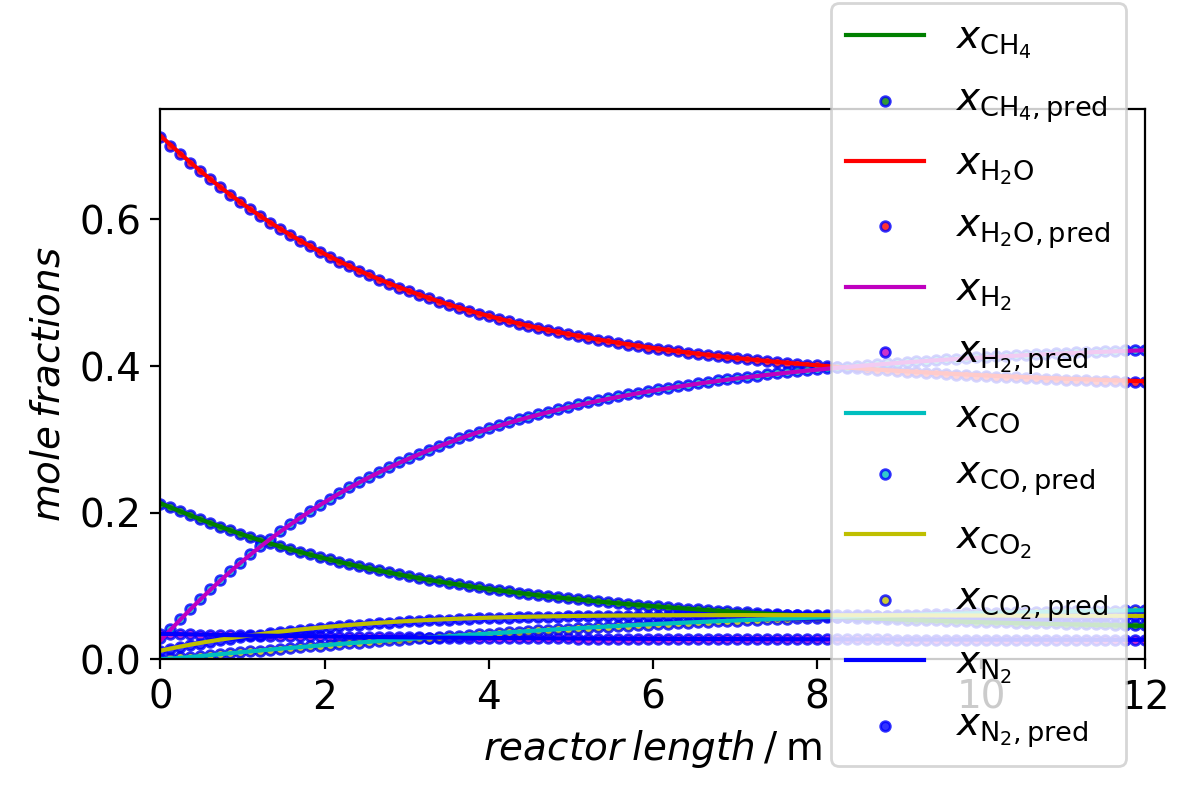

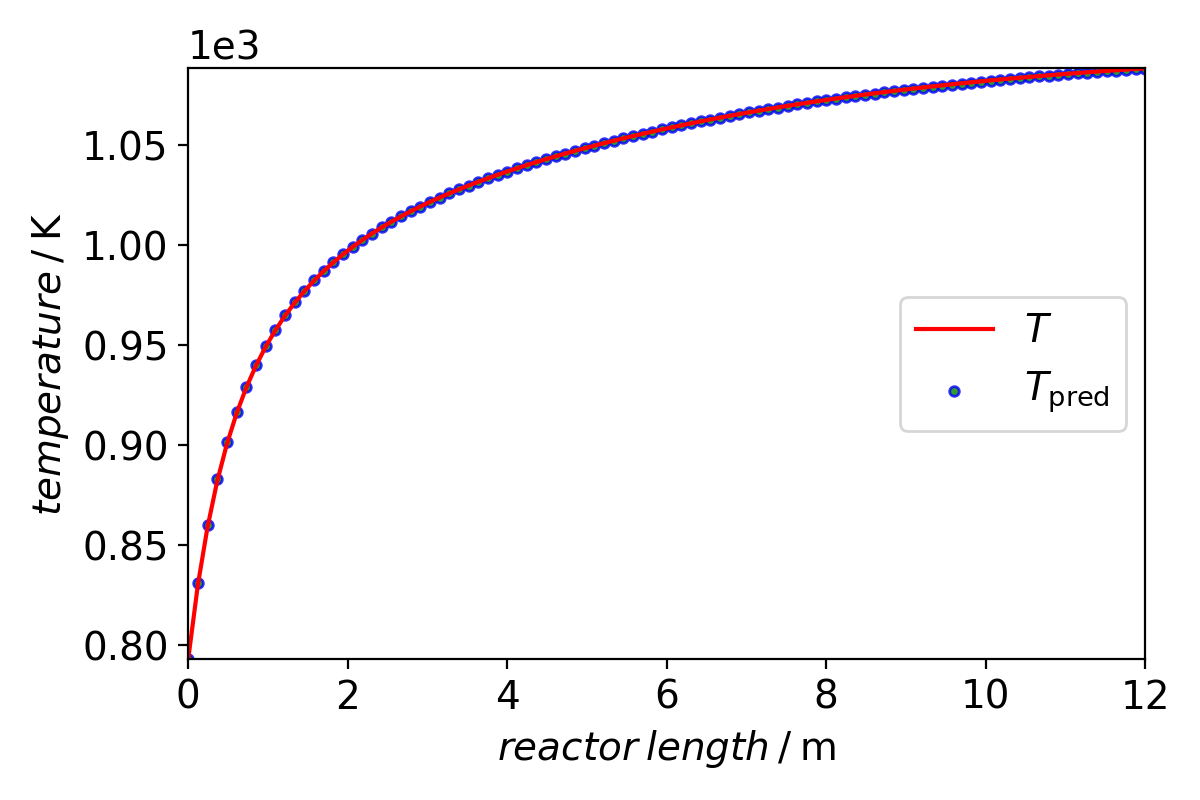

Next, we use the causal training algorithm to train the PIN. To use causal training algorithm, the causality parameter epsilon must be set to a value not equal 0.

In [ ]:
# Set the causality parameter unequal to 0
num_epochs = 50
epsilon = 0.05

# Set up the neural network
network = NeuralNetwork(input_size_NN=input_size_NN, hidden_size_NN=hidden_size_NN,\
                        output_size_NN=output_size_NN, num_layers_NN=num_layers_NN,\
                        T0 = bound_conds[2])
optimizer = torch.optim.LBFGS(network.parameters(), lr=1, line_search_fn= \
                                "strong_wolfe", max_eval=None, tolerance_grad \
                                    =1e-50, tolerance_change=1e-50)
        
x = torch.tensor(reactor_lengths.reshape(-1, 1), requires_grad=True)
y = None
    
# Train the neural network
calc_loss = PINN_loss(weight_factors, epsilon, inlet_mole_fractions, \
                        bound_conds, reactor_conds) 
        
loss_values = train(x, y, network, calc_loss, optimizer, num_epochs, analytical_solution_x_CH4, \
            analytical_solution_x_H20, analytical_solution_x_H2, analytical_solution_x_CO, \
            analytical_solution_x_CO2, analytical_solution_x_N2, analytical_solution_T, \
            model.n_N2_0, plot_interval)

The plots shown were determined using the listed parameters after a causal training with 800 epochs: 
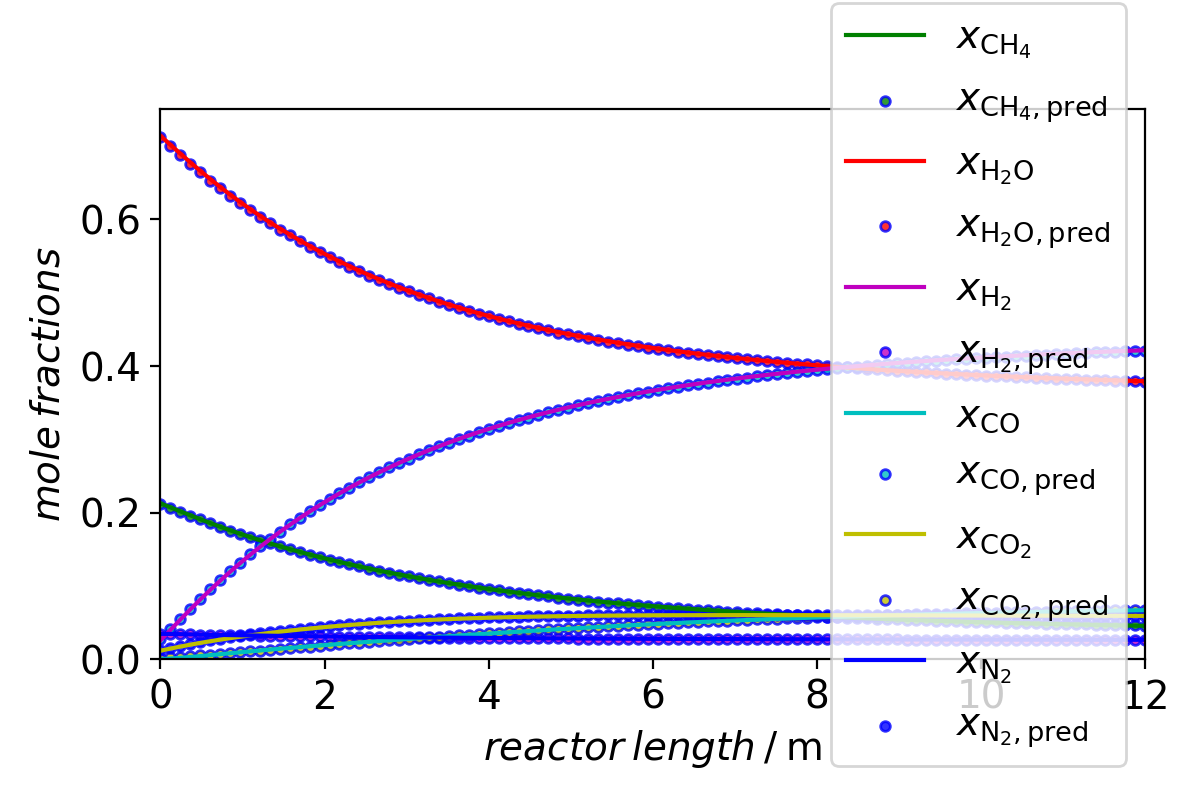

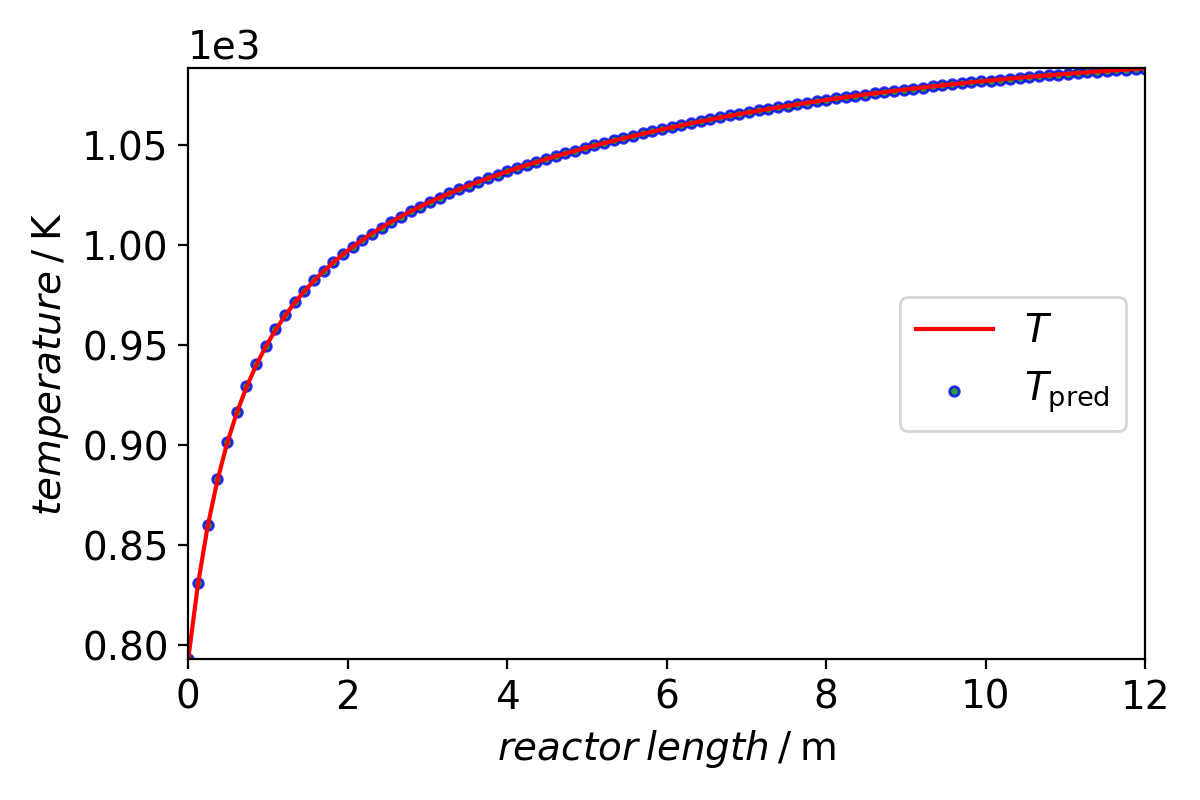